In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('전체 샘플수 :', (len(data)))
data.sample(10)

전체 샘플수 : 98401


,headlines,text
36156,Will do everything to ensure India's election ...,During his testimony before the US Congress on...
33554,Govt clears military equipment procurement wor...,The Defence Ministry on Friday cleared the pro...
82461,Microsoft puts artificial intelligence in Ã¢Â...,Microsoft researchers have installed computer ...
94613,The title of my biopic should be 'Sex God': Ra...,Actor Ranveer Singh has said that if a biopic ...
18464,UP CM directs invoking NSA against those invol...,UP CM Yogi Adityanath has directed investigati...
17017,Ola raises $50 mn from Chinese investors at $4...,Homegrown ride-hailing startup Ola has raised ...
84298,Bookies lost Ã¢ÂÂ¹2500 cr after India's loss ...,"Bookmakers reportedly lost up to Ã¢ÂÂ¹2,500 c..."
58673,Ready to pay political price to fight corrupti...,PM Narendra Modi on Thursday said that he migh...
68662,Indian man flies to Singapore to buy iPhone 8 ...,Indian businessman Amin Ahmed Dholiya flew to ...
57519,Ã¢ÂÂ¹100cr illegally transferred from Jharkha...,The CBI has registered a case in connection wi...


추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요

1. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. 
   두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

# 1. 추상적 요약

## 1-1 데이터 전처리하기

**중복 제거, Null 제거**

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

print(data.isnull().sum())

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360
headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


**텍스트 정규화(text normalization)**

In [5]:
nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))

불용어 개수 : 198


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [8]:
# 전체 Text 데이터에 대한 전처리 
clean_text = []

#clean_text = data['Text'].apply(lambda x: preprocess_sentence(str(x), remove_stopwords=True))

for t in data['text']:
  clean_text.append(preprocess_sentence(t, True))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [9]:
# 전체 Headlines 데이터에 대한 전처리 
clean_summary = []

#clean_summary = data['headlines'].apply(lambda x: preprocess_sentence(str(x), remove_stopwords=False))

for t in data['headlines']:
  clean_summary.append(preprocess_sentence(t, False))

print("Headlines 전처리 후 결과: ", clean_summary[:5])

Headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


In [12]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


**샘플의 최대 길이 정하기**

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


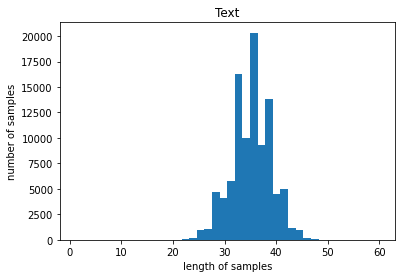

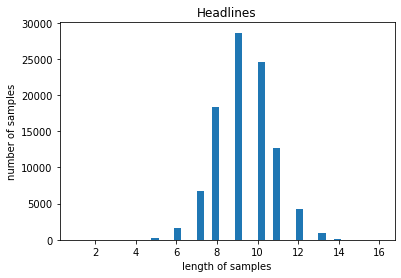

In [14]:
text_len = [len(str.split()) for str in data['text']]
summary_len = [len(str.split()) for str in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

               
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 60
summary_max_len = 16

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


**시작 토큰과 종료 토큰 추가하기**

In [20]:
# Headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


**훈련데이타와 테스트데이터 나누기**

In [29]:
#인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력 (sostoken ~)
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블 (~ eostoken)

# 인코더 입력과 같은 크기와 형태의 정수 시퀀스
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 샘플을 섞어준다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

# 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19672
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


**단어 집합(vocabulary) 만들기 및 정수 인코딩**

    Tokenizer()
    * fit_on_texts(texts)	전체 텍스트 데이터에 대해 단어 사전 구축
    * texts_to_sequences(texts)	텍스트를 정수 시퀀스로 변환
    * sequences_to_texts(sequences)	시퀀스를 다시 텍스트로 복원
    * texts_to_matrix(texts, mode='binary')	텍스트를 벡터화 (BoW, TF-IDF 등 지원)
    * word_index	단어와 정수 인덱스의 매핑 딕셔너리
    * index_word	인덱스 → 단어 매핑 (역변환)

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# src_tokenizer.word_index에 단어집합이 생성되어 있음

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69532
등장 빈도가 6번 이하인 희귀 단어의 수: 47377
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22155
단어 집합에서 희귀 단어의 비율: 68.13697290456193
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.490502303009589


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30103
등장 빈도가 5번 이하인 희귀 단어의 수: 19673
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10430
단어 집합에서 희귀 단어의 비율: 65.35229046938844
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.640717639292478


In [32]:
# total_cnt - rare_cnt 수로 단어 집합을 제한
# num_words	사용할 단어의 최대 개수 (빈도순 정렬 후 상위 n개만 사용)

src_vocab = 23000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 23,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('src_tokenizer.word_index :', len(src_tokenizer.word_index))

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

src_tokenizer.word_index : 69532
[[1408, 1429, 104, 422, 869, 232, 647, 691, 204, 53, 1777, 184, 647, 691, 1034, 4416, 3189, 706, 5592, 1290, 422, 271, 4416, 2380, 2029, 52, 109, 3101, 690, 4416, 1, 1550, 2350, 74, 263, 33, 180, 875, 861], [11, 2018, 58, 20706, 17, 8012, 7099, 58, 1130, 160, 57, 4763, 758, 3548, 878, 84, 742, 78, 779, 733, 81, 37, 1279, 2998, 4763, 249, 193, 3859, 175, 31, 1, 733, 1279, 418, 1262, 17, 11, 21, 16745, 412], [575, 894, 19433, 4343, 9285, 18399, 5528, 1517, 723, 25, 833, 35, 1256, 7100, 2395, 5528, 1517, 630, 7582, 2834, 61, 5529, 9286, 944, 22156, 30, 1536, 575, 318]]


In [33]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 189, 2480, 10, 3, 249, 3107, 332, 476, 471, 908, 148], [1, 1922, 1545, 10432, 1582, 13, 25, 1655], [1, 7640, 875, 1447, 1827, 5, 68], [1, 527, 864, 1196, 831, 3, 160, 115, 250, 2519, 616], [1, 1950, 430, 10, 1179, 3, 522, 304, 3]]
target
decoder  [[189, 2480, 10, 3, 249, 3107, 332, 476, 471, 908, 148, 2], [1922, 1545, 10432, 1582, 13, 25, 1655, 2], [7640, 875, 1447, 1827, 5, 68, 2], [527, 864, 1196, 831, 3, 160, 115, 250, 2519, 616, 2], [1950, 430, 10, 1179, 3, 522, 304, 3, 2]]


In [34]:
# sostoken만 있는 decoder_input
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# summary가 없으면, text(encoder)도 없어야 한다. 
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [35]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [36]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if( i==0):
            continue
        if(tar_index_to_word[i] == 'eostoken') :
            break
        temp = temp + tar_index_to_word[i]+' '
    return temp

**패딩하기**

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 1-2  어텐션 메커니즘 사용하기

### 훈련 모델

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))  # text_max_len로 크기 정해줌

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1   
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
#dec_emb = Embedding(tgt_vocab, embedding_dim)(decoder_inputs)

# 디코더의 LSTM
# 인코더의 hidden state와 cell state가 디코더의 초기 state로 사용.
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)  # 인코더와 concat한 결과를 사용

# 모델 정의
model_attention = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_attention .summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2944000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [41]:
model_attention.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model_attention.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=30)
# 시간이 너무 오래 걸려서, patience는 5 -> 2, epochs는 50 -> 20 으로 변경

Epoch 1/50
308/308 [==============================] - 51s 144ms/step - loss: 4.3312 - val_loss: 3.9565
Epoch 2/50
308/308 [==============================] - 45s 145ms/step - loss: 3.8392 - val_loss: 3.6787
Epoch 3/50
308/308 [==============================] - 46s 149ms/step - loss: 3.5966 - val_loss: 3.4920
Epoch 4/50
308/308 [==============================] - 46s 149ms/step - loss: 3.4026 - val_loss: 3.3521
Epoch 5/50
308/308 [==============================] - 46s 149ms/step - loss: 3.2468 - val_loss: 3.2414
Epoch 6/50
308/308 [==============================] - 46s 149ms/step - loss: 3.1165 - val_loss: 3.1550
Epoch 7/50
308/308 [==============================] - 46s 149ms/step - loss: 3.0048 - val_loss: 3.0944
Epoch 8/50
308/308 [==============================] - 46s 149ms/step - loss: 2.9087 - val_loss: 3.0420
Epoch 9/50
308/308 [==============================] - 46s 149ms/step - loss: 2.8241 - val_loss: 2.9985
Epoch 10/50
308/308 [==============================] - 46s 149ms/step - l

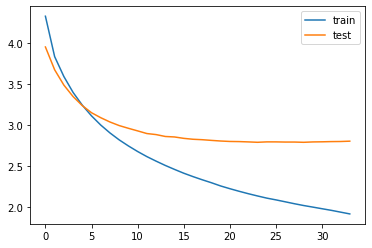

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 추론 모델

In [43]:

# 인코더 모델
# input : encoder_input
# output : last lstm layer 의 state_h, state_c
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])


In [44]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
# 디코더의 output과 hidden satte를 어텐션층에 전달하고 결과를 리턴
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
# input : decoder inputs, atteion_hidden_state, decoder_old_state_h & c, 
# output : decoder output, decoder_out_h_state, decoder_out_c_state
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i]+' '
    return temp

## 1-3. 실제 결과와 요약문 비교하기

In [48]:
print(type(encoder_input_test))

pred_loop_cnt = 30

<class 'numpy.ndarray'>


In [82]:
for i in range(1, 10):
    print("기사 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

기사 : bombay high court allowed three ailing com students appear exams despite low attendance exceptional medical grounds students filed petition college barred exams maintaining required attendance students reportedly could attend classes regularly one cancer others met accidents 
실제 헤드라인 : bombay hc allows students with low attendance to give exam 
예측 헤드라인 :  hc refuses to stay back to answer marks of neet


기사 : flipkart ceo kalyan krishnamurthy said changes flipkart operating processes result walmart deal acquire stake indian startup email sellers platform krishnamurthy said flipkart walmart maintain distinct brands keep making deep investments technology added 
실제 헤드라인 : no change in operating post walmart deal flipkart 
예측 헤드라인 :  flipkart will not be part of flipkart flipkart binny bansal


기사 : least two people killed others injured wednesday several gunmen stormed office indian ngo save children afghanistan jalalabad according reports attackers detonated car bomb outside office

In [50]:
samples = []
for i in range(1, pred_loop_cnt):
    samples.append({
        '기사': seq2text(encoder_input_test[i]),
        '실제 헤드라인': seq2summary(decoder_input_test[i]),
        '예측 헤드라인': decode_sequence(encoder_input_test[i].reshape(1, text_max_len))  
    })
    
pd.DataFrame(samples)

,원문,실제 요약,예측 요약
0,bombay high court allowed three ailing com stu...,bombay hc allows students with low attendance ...,hc refuses to stay back to answer marks of neet
1,flipkart ceo kalyan krishnamurthy said changes...,no change in operating post walmart deal flipk...,flipkart will not be part of flipkart flipkar...
2,least two people killed others injured wednesd...,gunmen storm save the children office in afgha...,killed in twin bomb attacks in afghanistan
3,story policewoman breastfeeding month old baby...,policewoman breastfeeds suspect baby while she...,newborn baby baby on newborn baby goes viral
4,exit polls predicted karnataka face hung assem...,exit polls predict hung assembly in karnataka,no confidence in gujarat assembly polls in taka
5,death year old boy due dengue sir ganga ram ho...,delhi witnesses its first dengue death this year,death toll in delhi boy dies in days
6,tokyo olympics paralympics selected elementary...,mascot chosen by children for tokyo olympics u...,indian football team makes trophy themed foot...
7,google parent company alphabet chairman eric s...,cannot guarantee ad will not show near offensi...,google parent alphabet ceo quits amid sexual ...
8,indian cricketer mahendra singh dhoni acquired...,ms dhoni acquires stake in sports tech startup...,flipkart acquires indian origin startup raise...
9,afghanistan fast bowler aftab alam broke conce...,afghan pacer cries after last over loss shoaib...,desh pacer takes wkts for nd straight win in ...


In [59]:
from rouge import Rouge


rouge = Rouge()

all_scores = []
results = []

for i in range(1, pred_loop_cnt):
    ref = seq2summary(decoder_input_test[i])
    pred = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))

    if ref.strip() == "" or pred.strip() == "":
        continue

    score = rouge.get_scores(pred, ref)[0]
    all_scores.append(score)
    
    results.append({
        'Index': i,
        'ROUGE-1': score['rouge-1']['f'],
        'ROUGE-2': score['rouge-2']['f'],
        'ROUGE-L': score['rouge-l']['f']
    })

rouge_1 = np.mean([s['rouge-1']['f'] for s in all_scores])
rouge_2 = np.mean([s['rouge-2']['f'] for s in all_scores])
rouge_l = np.mean([s['rouge-l']['f'] for s in all_scores])

print("📊 평균 ROUGE 점수")
print(f"ROUGE-1 F1: {rouge_1:.4f}")
print(f"ROUGE-2 F1: {rouge_2:.4f}")
print(f"ROUGE-L F1: {rouge_l:.4f}")   



📊 평균 ROUGE 점수
ROUGE-1 F1: 0.1824
ROUGE-2 F1: 0.0292
ROUGE-L F1: 0.1729


ROUGE 종류	좋은 점수 기준 (대략)
ROUGE-1	0.4 ~ 0.5 이상이면 양호
ROUGE-2	0.2 ~ 0.3 이상이면 괜찮음 (엄격)
ROUGE-L	0.3 ~ 0.4 이상이면 준수

ROUGE-2가 낮은 건 자연스러움 부족 or 단어 배열 정확도 부족
ROUGE-L이 높으면 핵심 구조는 잘 잡았다는 의미

--> 별로 좋지 않은 결과임

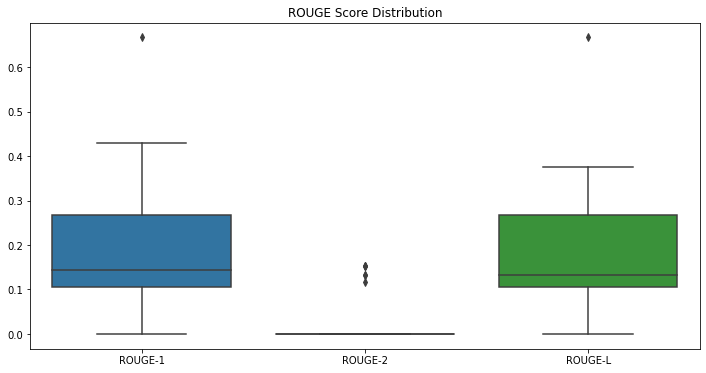

In [60]:
df = pd.DataFrame(results)
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']])
plt.title("ROUGE Score Distribution")
plt.show()

# 2. Summa을 이용해서 추출적 요약해보기

In [72]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

text = summa_data['text']
headline = summa_data['headlines']
print(text[:10])

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object


- Summa의 summarize()의 인자로 사용되는 값들
text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [64]:
print(type(text))

<class 'pandas.core.series.Series'>


In [68]:
from summa.summarizer import summarize

# Series 전체를 하나의 긴 문자열로 연결
#long_text = " ".join(text.dropna().astype(str).tolist())

#print('Summary:')
#print(summarize(long_text, ratio=0.5))

Summary:



In [85]:
from summa.summarizer import summarize

text = summa_data['text']
headline = summa_data['headlines']

all_scores = []
summa_results = []

for i in range(1, pred_loop_cnt):
    ref = str(text[i]).strip()
    pred = summarize( ref, ratio=0.5 )
    #pred = summarize( ref, words=20 )
    
    if( i< 10):
        print("기사 :", ref)
        print("실제 헤드라인 :", headline[i])
        print("요약 헤드라인 :", pred)
        print("\n")
  

    if ref.strip() == "" or pred.strip() == "":
        continue

    score = rouge.get_scores(pred, ref)[0]
    all_scores.append(score)
    
    summa_results.append({
        'Index': i,
        'ROUGE-1': score['rouge-1']['f'],
        'ROUGE-2': score['rouge-2']['f'],
        'ROUGE-L': score['rouge-l']['f']
    })

기사 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인 : Delhi techie wins free food from Swiggy for one year on CRED
요약 헤드라인 : Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


기사 : New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
실제 헤드라인 : New Zealand end Rohit Sharma-led India's

📊 평균 ROUGE 점수
ROUGE-1 F1: 0.6007
ROUGE-2 F1: 0.5496
ROUGE-L F1: 0.6007


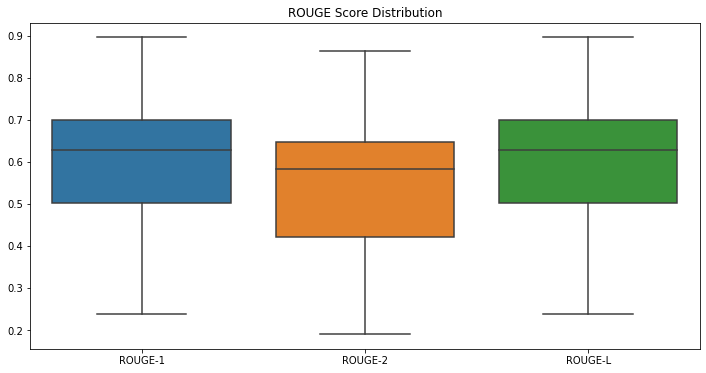

In [86]:
rouge_1 = np.mean([s['rouge-1']['f'] for s in all_scores])
rouge_2 = np.mean([s['rouge-2']['f'] for s in all_scores])
rouge_l = np.mean([s['rouge-l']['f'] for s in all_scores])

print("📊 평균 ROUGE 점수")
print(f"ROUGE-1 F1: {rouge_1:.4f}")
print(f"ROUGE-2 F1: {rouge_2:.4f}")
print(f"ROUGE-L F1: {rouge_l:.4f}")  

df = pd.DataFrame(summa_results)
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']])
plt.title("ROUGE Score Distribution")
plt.show()

# [ 회고 ]

| 항목               | Extractive 요약                               | Abstractive 요약                    |
|--------------------|-----------------------------------------------|------------------------------------|
| 문법 완성도        | 자연스럽지만 약간 어색하고 투박함             | 문법적을 간결하지만 아직 요약 성능이 안좋음 |
| 핵심 단어 포함 정도| 문장내에서 핵심 단어 추출함                   | 핵심단어를 아직 포함하지 못함      |
| ROUTE-L 점수       | 0.6007                                        | 0.1729                             |


기사 : bombay high court allowed three ailing com students appear exams despite low attendance exceptional medical grounds students filed petition college barred exams maintaining required attendance students reportedly could attend classes regularly one cancer others met accidents 
실제 헤드라인 : bombay hc allows students with low attendance to give exam 
예측 헤드라인 :  hc refuses to stay back to answer marks of neet

봄베이 고등법원은 출석률이 낮음에도 불구하고 병든 com 학생 3명의 시험 응시를 허용했습니다. 예외적인 의학적 근거로 학생들은 필수 출석 학생들이 정기적으로 수업에 참석할 수 있도록 요구하는 시험을 금지하는 청원서를 제출했습니다

봄베이 hc는 출석률이 낮은 학생들이 시험을 볼 수 있도록 합니다

hc는 그물 자국에 대한 답변을 거부합니다

기사 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인 : Delhi techie wins free food from Swiggy for one year on CRED
요약 헤드라인 : Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

쿠날 샤의 신용카드 청구서 결제 플랫폼인 CRED는 사용자에게 Swiggy로부터 1년 동안 무료 음식을 받을 수 있는 기회를 제공했습니다. 델리의 기술자 프라나브 카우식은 2000개의 CRED 코인을 사용한 후 이 보상을 받았습니다. 사용자는 청구서 결제 루피당 한 개의 CRED 코인을 받게 되며, 이를 통해 Ixigo, BookMyShow, UberEats, Cult.Fit 등의 브랜드에서 보상을 받을 수 있습니다

델리 테크니, 스위기로부터 1년간 무료 식품 제공 CRED 획득

사용자는 청구서 루피당 한 개의 CRED 코인을 지급받으며, 이를 통해 익시고, 북마이쇼, 우버이츠, 컬트핏 등의 브랜드에서 보상을 받을 수 있습니다

